# Minería de datos para grandes volúmenes de información 

Proyecto: Sistema de recomendación de películas 

Integrantes
Giovanny Gómez Convers - Sun Yin Huang Huang 
2023-2 

##Algoritmo de recomendación básico basado en popularidad

En este enfoque podemos explorar los datos observando cuales son las películas que han tenido un mayor numero de calificaciones(ratings) pero sin tener en cuenta el valor o contenido de su calificación(rango entre 0 y 5). Posteriormente, si tenemos en cuenta la calificación promedio.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("recPopularidad").getOrCreate()

#Previamente se han cargado los datos de movilens(https://grouplens.org/datasets/movielens/) a las tablas ratings y movies
ratings = spark.read.table("ratings")
movies = spark.read.table("movies")

#Calcular la popularidad de las películas basada en el número de calificaciones
movie_popularity = ratings.groupBy("movieId").count().withColumnRenamed("count", "Popular")

#Ordenar las películas por popularidad en orden descendente
popular_movies = movie_popularity.join(movies, "movieId", "inner").orderBy(col("Popular").desc())

#Veamos las 10 películas más populares
popular_movies.show(10)

#spark.stop()

+-------+-------+--------------------+--------------------+
|movieId|Popular|               title|              genres|
+-------+-------+--------------------+--------------------+
|    318| 122296|Shawshank Redempt...|         Crime|Drama|
|    356| 113581| Forrest Gump (1994)|Comedy|Drama|Roma...|
|    296| 108756| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|   2571| 107056|  Matrix, The (1999)|Action|Sci-Fi|Thr...|
|    593| 101802|Silence of the La...|Crime|Horror|Thri...|
|    260|  97202|Star Wars: Episod...|Action|Adventure|...|
|   2959|  86207|   Fight Club (1999)|Action|Crime|Dram...|
|    527|  84232|Schindler's List ...|           Drama|War|
|    480|  83026|Jurassic Park (1993)|Action|Adventure|...|
|   1196|  80200|Star Wars: Episod...|Action|Adventure|...|
+-------+-------+--------------------+--------------------+
only showing top 10 rows



In [0]:
from pyspark.sql.functions import col, avg, count

spark = SparkSession.builder.appName("recPopularidad").getOrCreate()

# Calcular la popularidad de las películas basada en el número de calificaciones y la calificación promedio
movie_ratings = ratings.groupBy("movieId").agg(
    avg(col("rating")).alias("avg_rating"),
    count(col("rating")).alias("num_ratings")
)

# Calcular una puntuación de popularidad ponderada (por ejemplo, usando el promedio y el número de calificaciones)
movie_popularity = movie_ratings.withColumn("Popular", col("avg_rating") * col("num_ratings"))

# Ordenar las películas por popularidad en orden descendente
popular_movies = movie_popularity.join(movies, "movieId", "inner").orderBy(col("Popular").desc())

# Mostrar las 10 películas más populares
popular_movies.show(10)


+-------+-----------------+-----------+------------------+--------------------+--------------------+
|movieId|       avg_rating|num_ratings|           Popular|               title|              genres|
+-------+-----------------+-----------+------------------+--------------------+--------------------+
|    318|4.416792045528881|     122296|          540156.0|Shawshank Redempt...|         Crime|Drama|
|    356|4.068189221788855|     113581|462068.99999999994| Forrest Gump (1994)|Comedy|Drama|Roma...|
|    296|4.191777924896098|     108756|          455881.0| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|   2571|4.160630884770588|     107056|445420.50000000006|  Matrix, The (1999)|Action|Sci-Fi|Thr...|
|    593|4.150286831299974|     101802|422507.49999999994|Silence of the La...|Crime|Horror|Thri...|
|    260|4.092400362132467|      97202|397789.50000000006|Star Wars: Episod...|Action|Adventure|...|
|   2959| 4.23601911677706|      86207|          365174.5|   Fight Club (1999)|Action|Crime

##Filtro colaborativo basado en memoria (vecinos cercanos)
Este tipo de algoritmo utilizamos la similitud entre usuarios para realizar la recomendación. Se implementa una medida de similaridad de coseno (correlación de Pearson)


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Define una función de similitud de coseno entre dos vectores
def cosine_similarity(vector1, vector2):
    dot_product = sum([a * b for a, b in zip(vector1, vector2)])
    magnitude1 = sum([a ** 2 for a in vector1]) ** 0.5
    magnitude2 = sum([a ** 2 for a in vector2]) ** 0.5
    return dot_product / (magnitude1 * magnitude2)

# Crear una sesión de Spark
spark = SparkSession.builder.appName("recColabMemoria").config("spark.sql.pivotMaxValues", 83239).getOrCreate()#ratings.select("movieId").distinct().count()

#Previamente se han cargado los datos de movilens(https://grouplens.org/datasets/movielens/) a las tablas ratings y movies
ratings = spark.read.table("ratings")
movies = spark.read.table("movies")

# Calcular la similitud de coseno entre usuarios
user_features = ratings.groupBy("userId").pivot("movieId").agg({"rating": "first"})#podriamos tomar el promedio(avg) o el máximo(max)
user_features = user_features.fillna(0)  # Rellenar valores nulos con 0

# Crear un ensamblador de vectores
input_cols = [str(movieId) for movieId in user_features.columns if movieId != "userId"]
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
user_features = assembler.transform(user_features)

# Escalar las características
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(user_features)
user_features = scaler_model.transform(user_features)

# Realizar un agrupamiento de usuarios
num_clusters = 10
kmeans = KMeans(featuresCol="scaled_features", k=num_clusters, seed=1)
model = kmeans.fit(user_features)
user_features = model.transform(user_features)

# Obtener un usuario de ejemplo y encontrar usuarios similares
target_user_id = 1
target_user_features = user_features.filter(col("userId") == target_user_id).select("scaled_features").collect()[0][0]

# Calcular la similitud de coseno entre usuarios y encontrar usuarios similares
udf_cossim = udf(cosine_similarity, DoubleType())
user_features = user_features.withColumn("similarity", udf_cossim(target_user_features, user_features.scaled_features))
similar_users = user_features.orderBy(col("similarity").desc()).limit(10)

# Calcular las valoraciones previstas para el usuario de destino
similar_user_ids = similar_users.select("userId").rdd.flatMap(lambda x: x).collect()
user_ratings = ratings.filter(col("userId") == target_user_id)
similar_user_ratings = ratings.filter(col("userId").isin(similar_user_ids))
predicted_ratings = similar_user_ratings.alias("su").join(user_ratings.alias("u"), on=["movieId"], how="left") \
    .filter(col("u.userId").isNull()).select("su.movieId", "su.rating")

# Mostrar las recomendaciones
recommended_movies = predicted_ratings.orderBy(col("rating").desc()).limit(10)

# Unirse con la tabla de películas para obtener detalles de las películas recomendadas
recommended_movies_with_details = recommended_movies.join(movies, on=["movieId"], how="left")

# Mostrar las películas recomendadas
recommended_movies_with_details.show()

##Filtro colaborativo basado en modelos
Este tipo de algoritmo utiliza técnicas de Machine Learning, tales como ALS()


In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Crear una sesión de Spark
spark = SparkSession.builder.appName("RecALS").getOrCreate()

#Previamente se han cargado los datos de movilens(https://grouplens.org/datasets/movielens/) a las tablas ratings y movies
ratings = spark.read.table("ratings")
movies = spark.read.table("movies")

# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
(train, test) = ratings.randomSplit([0.8, 0.2], seed=123)

# Configurar el modelo ALS
als = ALS(
    maxIter=10,
    regParam=0.01,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"
)

# Ajustar el modelo a los datos de entrenamiento
model = als.fit(train)

# Realizar predicciones en el conjunto de prueba
predictions = model.transform(test).dropna()

# Realizar recomendaciones para usuarios en el conjunto de prueba
user_recs = model.recommendForAllUsers(10)  # Genera 10 recomendaciones por usuario

# Calcular el RMSE en el conjunto de prueba
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

# Calcular el RMSE
rmse = evaluator.evaluate(predictions)

print(f"RMSE: {rmse}")


RMSE: 0.8218877877631716


##Filtrado basado en contenido
Se evaluan las caracteristicas de las películas y las preferencias previas del usuario.



In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Crear una sesión de Spark
spark = SparkSession.builder.appName("RecContenido").getOrCreate()

#Previamente se han cargado los datos de movilens(https://grouplens.org/datasets/movielens/) a las tablas ratings y movies
ratings = spark.read.table("ratings")
movies = spark.read.table("movies")

# Separar los géneros en una lista de Python
movies_with_genres = movies.withColumn("genres_list", split(movies.genres, "\\|"))

# Explode (dividir) la lista de géneros en filas separadas
exploded_movies = movies_with_genres.select("movieId", explode("genres_list").alias("genre"))

# Etiquetar los géneros con un índice numérico
indexer = StringIndexer(inputCol="genre", outputCol="genreIndex")
indexed_movies = indexer.fit(exploded_movies).transform(exploded_movies)

# Crear un vector de características para las películas
assembler = VectorAssembler(inputCols=["genreIndex"], outputCol="features")
feature_movies = assembler.transform(indexed_movies)

# Dividir los datos en conjuntos de entrenamiento y prueba
(train, test) = ratings.randomSplit([0.8, 0.2], seed=123)

# Configurar el modelo ALS para filtrado colaborativo basado en contenido
als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"
)

# Crear un pipeline para entrenar el modelo ALS
pipeline = Pipeline(stages=[als])
model = pipeline.fit(train)

# Realizar predicciones en el conjunto de prueba
predictions = model.transform(test).dropna()

evaluator = RegressionEvaluator(
    labelCol="rating",  # Columna de calificaciones reales
    predictionCol="prediction",  # Columna de predicciones
    metricName="rmse"  # Tipo de métrica a calcular (en este caso, RMSE)
)

# Calcular el RMSE
rmse = evaluator.evaluate(predictions)
print(f"RMSE en el conjunto de prueba: {rmse}")



RMSE en el conjunto de prueba: 0.8072531950693929


Graficar resultados


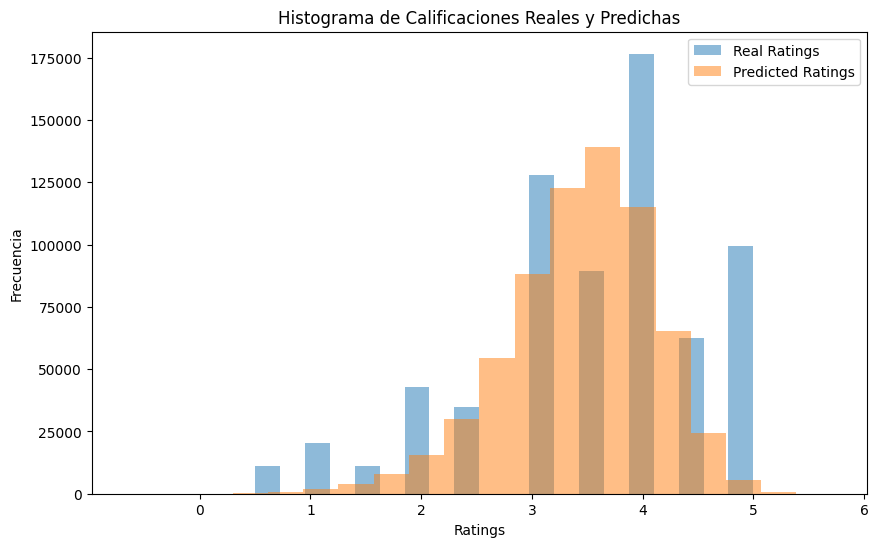

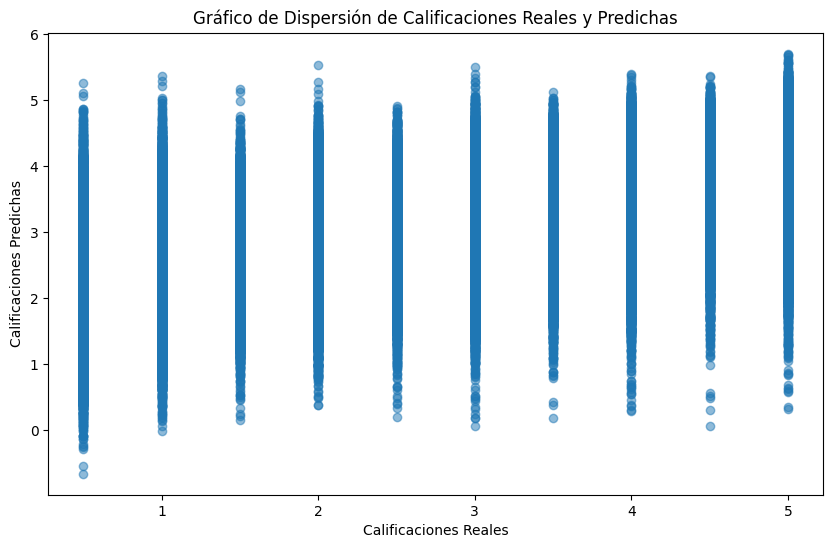

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Especificar el tamaño de la muestra deseada (porcentaje de las predicciones)
sample_size = 0.10  # Ejemplo: 10% de las predicciones

# Tomar una muestra aleatoria del DataFrame de predicciones
predictions_pandas = predictions.sample(withReplacement=False, fraction=sample_size, seed=42)

# Convertir el DataFrame de PySpark a un DataFrame de Pandas
predictions_pandas = predictions_pandas.select("rating", "prediction").toPandas()


# Punto 1: Histograma de Calificaciones Reales y Predichas
plt.figure(figsize=(10, 6))
plt.hist(predictions_pandas["rating"], bins=20, alpha=0.5, label="Real Ratings")
plt.hist(predictions_pandas["prediction"], bins=20, alpha=0.5, label="Predicted Ratings")
plt.legend()
plt.xlabel("Ratings")
plt.ylabel("Frecuencia")
plt.title("Histograma de Calificaciones Reales y Predichas")
plt.show()

# Punto 2: Gráfico de Dispersión (Scatter Plot)
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pandas["rating"], predictions_pandas["prediction"], alpha=0.5)
plt.xlabel("Calificaciones Reales")
plt.ylabel("Calificaciones Predichas")
plt.title("Gráfico de Dispersión de Calificaciones Reales y Predichas")
plt.show()






Graficar convergencia de modelos ALS


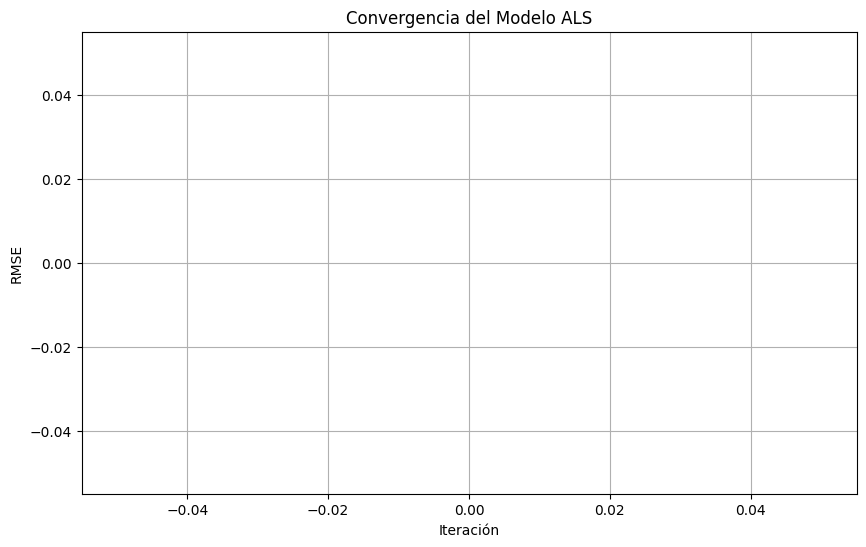

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator



# Dividir los datos en conjuntos de entrenamiento y prueba
(train, test) = ratings.randomSplit([0.8, 0.2], seed=123)

# Inicializar el modelo ALS
als = ALS(
    maxIter=10,  # Número de iteraciones
    regParam=0.01,  # Parámetro de regularización
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating"
)

# Crear listas para registrar los valores de RMSE en cada iteración
iterations = []
rmse_values = []

for iteration in range(1, als.getMaxIter() + 1):
    # Entrenar el modelo con la iteración actual
    model = als.fit(train)

    # Realizar predicciones en el conjunto de prueba
    predictions = model.transform(test)

    # Calcular el RMSE para esta iteración
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    
    # Registrar los valores
    iterations.append(iteration)
    rmse_values.append(rmse)

# Crear el gráfico de convergencia
plt.figure(figsize=(10, 6))
plt.plot(iterations, rmse_values, marker='o', linestyle='-')
plt.title("Convergencia del Modelo ALS")
plt.xlabel("Iteración")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()
